In [1]:
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen
import medmnist
from medmnist import INFO, Evaluator
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

In [5]:
data_flag = 'breastmnist'
download = True
NUM_EPOCHS = 3
BATCH_SIZE = 64
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

100%|██████████| 560k/560k [00:00<00:00, 2.15MB/s]


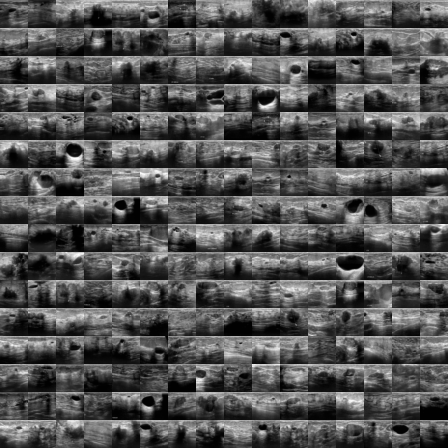

In [6]:
# data augmentation

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5],std=[.5])
])

train = DataClass(split='train', transform=data_transform, download=download)
test = DataClass(split='test', transform=data_transform, download=download)

train_loader = data.DataLoader(dataset=train, batch_size=BATCH_SIZE, shuffle=True)
train_loader_eval = data.DataLoader(dataset=train, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test, batch_size = 2*BATCH_SIZE, shuffle=False)

train.montage(length=16)

In [ ]:
# Leaky ConvNet
    # overrides the backward pass
class LeakySigmoidSurrogate(nn.Module):
    def __init__(self,beta, threshold=1.0, k=25):
        self.beta = beta
        self.threshold = threshold
        self.surrogate_func = self.FastSigmoid.apply

    def forward(self, input_, mem):
        spk = self.surrogate_func((mem-self.threshold)) # Heaviside function
        reset = (spk - self.threshold).detach()
        mem = self.beta * mem + input_ - reset
        return spk, mem
    
    @staticmethod
    class FastSigmoid(torch.autograd.Function):
        @staticmethod
        def forward(ctx, mem, k=25):
            ctx.save_for_backward(mem) # membrane potential for backward pass
            ctx.k = k
            out = (mem>0).float() # Heaviside
            return out
        
        @staticmethod
        def backward(ctx, grad_output):
            (mem,) = ctx.saved_tensors # membrane potential
            grad_input = grad_output.clone()
            grad = grad_input / (ctx.k * torch.abs(mem) + 1.0) ** 2 # fast sigmoid gradient
            return grad, None

spike_grad = surrogate.fast_sigmoid(slope=25)
beta = 0.5
lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
